# <center> Tarea 3: Geometria Computacional y Diferencial</center>
<center>Juan Manuel Ramirez Osuna</center>

## Librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from sympy import lambdify
from sympy import Matrix
from scipy.spatial import Voronoi, voronoi_plot_2d
import geopandas
import matplotlib.pyplot as plt
from scipy import integrate
     

## Primera parte

          Concavidad  Perimetro
ID                             
842302          3001       1228
842517           869       1329
84300903        1974        130
84348301        2414       7758
84358402         198       1351
...              ...        ...
926125          3174        143
926424          2439        142
926682           144       1312
926954          9251       1083
927241          3514       1401

[491 rows x 2 columns]


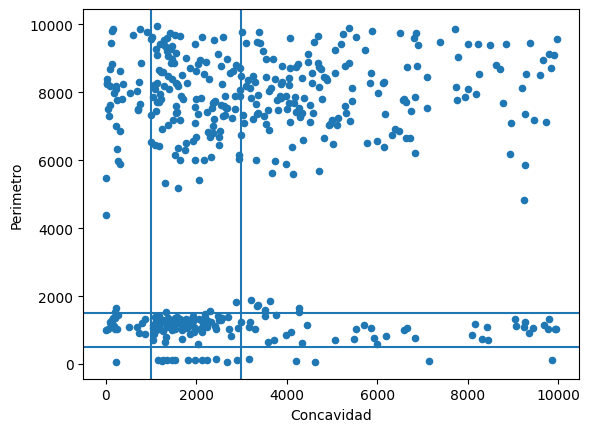

In [2]:
cancer = pd.read_csv('https://raw.githubusercontent.com/nicoavilan/Bases-de-datos/main/cancer2.csv', index_col=0)
df = cancer[['Concavidad','Perimetro']]
print(df)
df.plot.scatter(x ='Concavidad', y = 'Perimetro')
plt.axvline(x = 1000)
plt.axvline(x = 3000)
plt.axhline(y = 500)
plt.axhline(y = 1500)
plt.show()

In [3]:
# Nodo
# Input: Valor de nodo, en este caso es una serie de la libreria pandas
#        (opcional) Nodo de hijo izquierdo, nodo de hijo derecho, nodo de padre, lista de listas o serie de pandas indicando 
#                   la region de particion e indice de columna de busqueda

class Node:
    def __init__(self, val, lc = None, rc = None, parent = None, reg = None, i = 0):
        self.val = val
        self.lc = lc
        self.rc = rc
        self.parent = parent
        if reg:
            self.reg = reg
        else:
            self.reg = self.val

# Dataframe a arbol
# Input: Dataframe con datos a buscar
#        (opcional): Nodo padre de nodo a revizar, indice de columna sobre la cual dividir
def df2tree(df, parent = None, i = 0):
    # Organizar df de manera intercalada
    df_sorted = df.sort_values(by=[df.columns[i]])
    n = len(df_sorted) 
    # Nodo medio
    current = Node(df_sorted.iloc[n//2,:], parent = parent,\
                   reg = [[min(df[df.columns[0]]), max(df[df.columns[0]])],\
                          [min(df[df.columns[1]]), max(df[df.columns[1]])]], i = i)
    if n > 1:
        # Si es unitario solo considera valor "central"
        i = (i+1)%2
        current.lc = df2tree(df_sorted.iloc[:n//2,:], parent = current, i = i)
        if n > 2:
            # Si es mayor a 2 solo genera hijo izquierdo
            current.rc = df2tree(df_sorted.iloc[n//2+1:,:], parent = current, i = i)
    return current

# Busqueda sobre arbol de k dimensiones
# Input: Raiz del arbol y region de busqueda
# Output: Dataframe con datos dentro de la region
def busquedakd(root, R):
    # Revisa si es hoja
    if root.rc == None and root.lc == None:
        if (root.val[0] >= R[0][0] and root.val[0] <= R[0][1])\
        and (root.val[1] >= R[1][0] and root.val[1] <= R[1][1]):
            return root.val.to_frame().T
    else:
        lr = None
        rr = None
        # Iniciando por izquierda
        if isinstance(root.lc.reg,pd.Series):
            # Izquierda es hoja
            lr = busquedakd(root.lc, R)
        elif (root.lc.reg[0][0] >= R[0][0] and root.lc.reg[0][1] <= R[0][1])\
        and (root.lc.reg[1][0] >= R[1][0] and root.lc.reg[1][1] <= R[1][1]):
            # Izquierda contenida por busqueda
            lr = tree2df(root.lc).T
        elif reg_inter(root.lc.reg, R):
            # Izquierda con interseccion a busqueda
            lr  = busquedakd(root.lc, R)
        if root.rc:
            # Revisa si existe un hijo derecho
            if isinstance(root.rc.reg,pd.Series):
                # Derecho es hoja
                rr = busquedakd(root.lc, R)
            elif (root.rc.reg[0][0] >= R[0][0] and root.rc.reg[0][1] <= R[0][1])\
            and (root.rc.reg[1][0] >= R[1][0] and root.rc.reg[1][1] <= R[1][1]):
                # Derecho contenido por busqueda
                rr = tree2df(root.rc).T
            elif reg_inter(root.rc.reg, R):#((root.rc.reg[0][0] < R[0][0] and root.rc.reg[0][1] > R[0][1]) and (root.rc.reg[1][0] < R[1][0] and root.rc.reg[1][1] > R[1][1])) or (((root.rc.reg[0][0] > R[0][0] and root.rc.reg[0][0] < R[0][1]) or (root.rc.reg[0][1] > R[0][0] and root.rc.reg[0][1] < R[0][1]) or (root.rc.reg[0][0] < R[0][0] and root.rc.reg[0][1] > R[0][1])) and ((root.rc.reg[1][0] > R[1][0] and root.rc.reg[1][0] < R[1][1]) or (root.rc.reg[1][1] > R[1][0] and root.rc.reg[1][1] < R[1][1]) or (root.rc.reg[1][0] < R[1][0] and root.rc.reg[1][1] > R[1][1]))):
                # Derecho con interseccion a busqueda
                rr = busquedakd(root.rc, R)
        # Valor de nodo
        me = None
        if (root.val[0] >= R[0][0] and root.val[0] <= R[0][1])\
        and (root.val[1] >= R[1][0] and root.val[1] <= R[1][1]):
            # Valor de nodo contenido en busqueda
            me = root.val.to_frame()
            
        if lr is not None:
            # Hay izquierdo
            if rr is not None:
                if len(lr) == 1 and len(rr) == 1:
                    # Izquierdo y derecho son hojas
                    return pd.concat([lr, me, rr], axis=0)
                else:
                    # Se inicia por volver horizontales los dfs verticales
                    if len(lr.columns.intersection(['Concavidad', 'Perimetro'])) != 0:
                        lr = lr.T
                    if len(rr.columns.intersection(['Concavidad', 'Perimetro'])) != 0:
                        rr = rr.T
                    return pd.concat([lr, me,rr], axis=1).T
            else:
                # No hay derecho
                if len(lr) == 1:
                    # Izquierdo hoja
                    return pd.concat([lr.T, me], axis=1).T
                else:
                    # Izquierdo dataframe
                    return pd.concat([lr.T, me], axis=1).T
        elif type(rr) != 'NoneType':
            # Hay derecho
            return pd.concat([me,rr.T], axis=1).T

# Interseccion entre regiones
# Input: Dos listas [x,y] de listas [x1,x2] de coordenadas de la region cuadrada
# Output: Booleano indicando si existe o no interseccion
def reg_inter(reg1, reg2):
    # reg 1 contiene a reg 2:
    cond1 = (reg2[0][0] > reg1[0][0] and reg2[0][1] < reg1[0][1])\
            and (reg2[1][0] > reg1[1][0] and reg2[1][1] < reg1[1][1])
    # interseccion en proyeccion sobre x
    cond2 = (reg1[0][0] > reg2[0][0] and reg1[0][0] < reg2[0][1]) or\
          (reg1[0][1] > reg2[0][0] and reg1[0][1] < reg2[0][1]) or\
          (reg1[0][0] < reg2[0][0] and reg1[0][1] > reg2[0][0]) or\
          (reg1[0][0] < reg2[0][1] and reg1[0][1] > reg2[0][1])  
    # interseccion en proyeccion sobre y
    cond3 = (reg1[1][0] > reg2[1][0] and reg1[1][0] < reg2[1][1]) or\
          (reg1[1][1] > reg2[1][0] and reg1[1][1] < reg2[1][1]) or\
          (reg1[1][0] < reg2[1][0] and reg1[1][1] > reg2[1][0]) or\
          (reg1[1][0] < reg2[1][1] and reg1[1][1] > reg2[1][1])  
    return cond1 or (cond2 and cond3)
        
# Arbol a dataframe
# Input: Raiz del arbol
# Output: dataframe con valores del arbol
def tree2df(root):
    if root:
        if root.lc or root.rc:
            return pd.concat([tree2df(root.rc), root.val, tree2df(root.lc)], axis=1)#, ignore_index=True)
        else:
            return root.val.to_frame()

# En orden
# Input: raiz de arbol
# Output: vector de valores del arbol de menor a mayor
def inorder(root):
    result = [] 
    if root:
        result.extend(inorder(root.lc))
        result.append((root.val))
        result.extend(inorder(root.rc))
    return result

In [4]:
τ = df2tree(df)
encontrados = busquedakd(τ, [[1000,3000],[500,1500]])

In [5]:
print(encontrados)

          Concavidad  Perimetro
855563          1044        719
86730502        1043       1062
877989          1036       1151
855138          1063        884
872608          1307        646
...              ...        ...
907914          2733       1021
899667          2914       1071
884948          2712       1389
895100          2565       1359
866674          2545       1304

[82 rows x 2 columns]


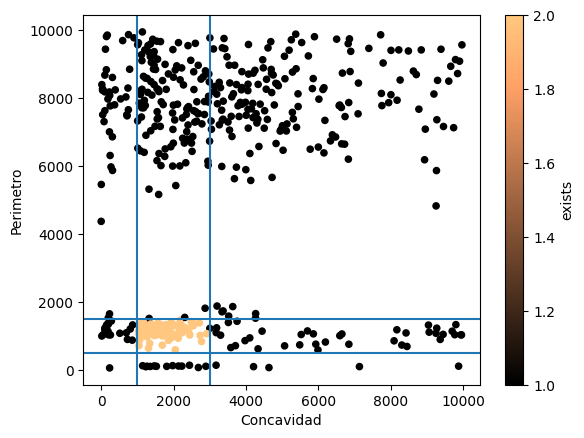

In [6]:
df2 = df
df2 = pd.merge(df2, encontrados, on=['Concavidad', 'Perimetro'], how='left', indicator='exists')
df2['exists'] = (df2['exists'] == 'both') + 1
df2.plot.scatter(x ='Concavidad', y = 'Perimetro', c = 'exists', cmap = 'copper')
plt.axvline(x = 1000)
plt.axvline(x = 3000)
plt.axhline(y = 500)
plt.axhline(y = 1500)
plt.show()

### Segunda pregunta

In [7]:
url='https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/3aadedf47badbdac823b00dbe259f6bc6d9e1899/colombia.geo.json'
col = geopandas.read_file(url)

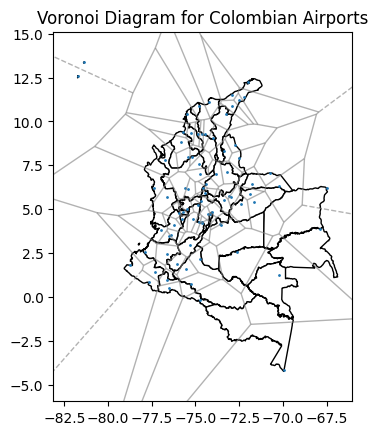

In [8]:
cancer = pd.read_csv('https://raw.githubusercontent.com/nicoavilan/Bases-de-datos/main/airports_CO.csv')
fig, axs = plt.subplots()
df = cancer[['Longitud','Latitud']]
col.plot(color= "white", figsize=(12,7),edgecolor="black", ax =axs)
#axs.scatter(x = df['Longitud'], y = df['Latitud'])
vor = Voronoi(df)
fig = voronoi_plot_2d(vor, ax = axs, show_vertices = False,
                      line_colors='grey', line_width=1, line_alpha=0.6, point_size=2)
plt.title('Voronoi Diagram for Colombian Airports')
plt.show()

## Segunda parte

In [9]:
# Norma
# Input: vector de sympy
# Output: Entero de norma de vector 
def norma(x):
    return sp.sqrt(x.dot(x)).simplify()

### Tercera pregunta

#### Curva y tangente

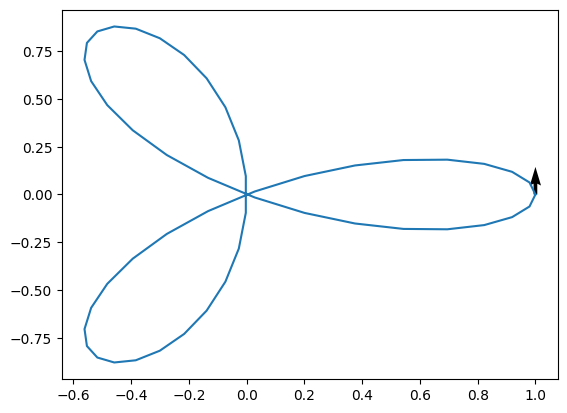

In [10]:
t = sp.symbols('t')

x = sp.cos(3*t)*sp.cos(t)
y = sp.cos(3*t)*sp.sin(t)
z = 0

α = Matrix([x,y,z])
w = np.linspace(0, np.pi)
X = lambdify(t, x)(w)
Y = lambdify(t, y)(w)
plt.plot(X,Y)


dα = α.diff(t)
dα_norma = norma(dα)
T = dα/dα_norma
plt.quiver(lambdify(t, x)(0), lambdify(t, y)(0), lambdify(t, T[0])(0), lambdify(t, T[1])(0))
plt.show()

#### Curvatura

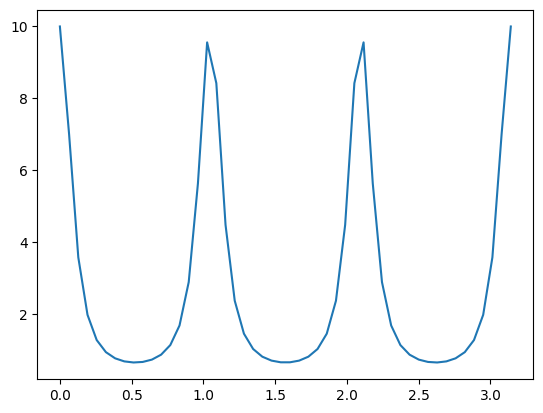

In [11]:
ddα = α.diff(t,2)
κ = norma(dα.cross(ddα))/dα_norma**3
K = lambdify(t,κ)(w)
plt.plot(w,K)
plt.show()

#### Longitud de curva

In [12]:
print(f'La longitud de la curva es: {sp.integrate(dα_norma,(t,0,sp.pi)).evalf()}')

La longitud de la curva es: 6.68244661027763


#### Indice de torsion

In [13]:
i = lambdify(t,κ*dα_norma)
I = integrate.quad(i, 0, np.pi)
print(f'El vector tangente dio aproximadamente {I[0]/(2*np.pi)} rotaciones completas al recorrer la curva')

El vector tangente dio aproximadamente 1.999999999999991 rotaciones completas al recorrer la curva


### Cuarta pregunta

#### Curva y tangente

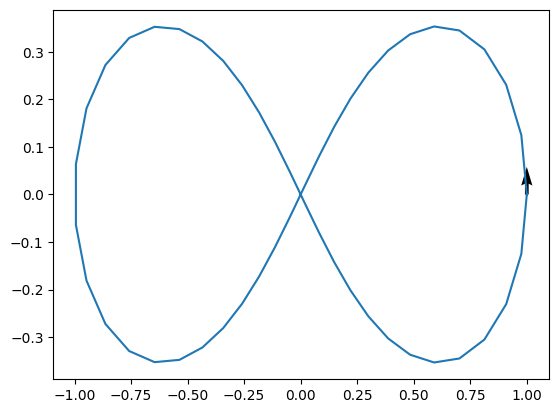

In [14]:
t = sp.symbols('t')

x = sp.cos(t)/(1+sp.sin(t)**2)
y = sp.cos(t)*sp.sin(t)/(1+sp.sin(t)**2)
z = 0

α = Matrix([x,y,z])
w = np.linspace(0, 2*np.pi)
X = lambdify(t, x)(w)
Y = lambdify(t, y)(w)
plt.plot(X,Y)


dα = α.diff(t)
dα_norma = norma(dα)
T = dα/dα_norma
plt.quiver(lambdify(t, x)(0), lambdify(t, y)(0), lambdify(t, T[0])(0), lambdify(t, T[1])(0))
plt.show()

#### Curvatura

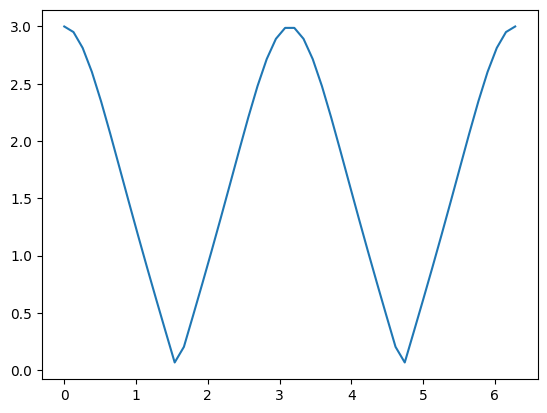

In [15]:
ddα = α.diff(t,2)
κ = norma(dα.cross(ddα))/dα_norma**3
K = lambdify(t,κ)(w)
plt.plot(w,K)
plt.show()

#### Longitud de curva

In [16]:
print(f'La longitud de la curva es: {sp.integrate(dα_norma,(t,0,2*sp.pi)).evalf()}')

La longitud de la curva es: 5.24411510858424


#### Indice de torsion

In [17]:
i = lambdify(t,κ*dα_norma)
I = integrate.quad(i, 0, np.pi)
print(f'El vector tangente dio aproximadamente {I[0]/(2*np.pi)} rotaciones completas al recorrer la curva')

El vector tangente dio aproximadamente 0.75 rotaciones completas al recorrer la curva


### Quinta pregunta

$$
        \tau(t) = -\frac{(\alpha '(t) \times \alpha ''(t))\cdot \alpha '''(t)}{|\alpha '(t)\times \alpha ''(t)|^2}
$$

Considere las formulas de frenet vistas en clase:
$$
\begin{align}
\frac{dT}{ds} = & \kappa N \\
\frac{dB}{ds} = & \tau N \\
\frac{dN}{ds} = & -\tau B - \kappa T
\end{align}
$$
Notese que siendo s una parametrizacion de longitud de curva de 1. De modo que para un caso de una longitud distinta se tiene:
$$
\frac{ds}{dt} = \frac{d\alpha(t)}{dt} = |\alpha'|
$$
De modo que:
$$
\begin{align}
\frac{dT}{ds} = & \frac{ds}{dt}\frac{dT}{ds} = \frac{dT}{dt} = \frac{ds}{dt}\kappa N = |\alpha'|\kappa N\\
\frac{dB}{ds} = & \frac{ds}{dt}\frac{dB}{ds} = \frac{dB}{dt} = \frac{ds}{dt}\tau N = |\alpha'|\tau N\\
\frac{dN}{ds} = & \frac{ds}{dt}\frac{dN}{ds} = \frac{dN}{dt} =  -\frac{ds}{dt}\tau B - \frac{ds}{dt}\kappa T =  -|\alpha'|\tau B - |\alpha'|\kappa T
\end{align}
$$
De la definicion de tangente se tiene:
$$
\alpha '(t) = |\alpha '|T\\
$$
Derivando en ambos lados se tiene:
$$
\alpha ''(t) = T'|\alpha '|+T|\alpha ''|
$$
Reemplazando la ecuacion de frenet de T'
$$
\alpha ''(t) = |\alpha '|^2\kappa N+T|\alpha ''|
$$
Derivando otra vez:
$$
\alpha '''(t) = (2|\alpha '||\alpha ''|\kappa + |\alpha '|^2\kappa')N+ |\alpha '|^2\kappa N' + 
T'|\alpha ''|+T|\alpha '''|\\
$$
Reemplazando la ecuacion de frenet de T' y N'
$$
\begin{align}
\alpha '''(t) = & (2|\alpha '||\alpha ''|\kappa + |\alpha '|^2\kappa')N+ |\alpha '|^2\kappa (-|\alpha'|\tau B - |\alpha'|\kappa T) + 
|\alpha ''||\alpha'|\kappa N+T|\alpha '''|\\
 = & (3|\alpha '||\alpha ''|\kappa + |\alpha '|^2\kappa')N - |\alpha '|^3\kappa \tau B + (|\alpha '''|-|\alpha'|^3\kappa) T
\end{align}
$$
Usando las derivadas previamente encontradas se obtiene:
$$
\begin{align}
\alpha ' \times \alpha '' = & |\alpha '|T \times (|\alpha '|^2\kappa N+T|\alpha ''|) \\
= & |\alpha '|T \times |\alpha '|^2\kappa N+ |\alpha '|T \times T|\alpha ''| \\
= & |\alpha '|^3 \kappa B
\end{align}
$$
Despejando $\kappa$ y aplicando la norma en ambos lados:
$$
\kappa = \frac{|\alpha ' \times \alpha ''|}{|\alpha '|^3 }
$$
Aplicando el producto punto del denominador deseado:
$$
(\alpha ' \times \alpha '')\cdot \alpha ''' = |\alpha '|^3 \kappa B \cdot ((3|\alpha '||\alpha ''|\kappa + |\alpha '|^2\kappa')N - |\alpha '|^3\kappa \tau B + (|\alpha '''|-|\alpha'|^3\kappa) T)
$$
Aprovechando que $B\cdot N = 0$, $B \cdot T = 0$ y $|B| = 1$:
$$
(\alpha ' \times \alpha '')\cdot \alpha ''' = |\alpha '|^6\kappa^2 \tau
$$
Reemplazando $\kappa$ encontrado previamente:
$$
(\alpha ' \times \alpha '')\cdot \alpha ''' = |\alpha '|^6\frac{|\alpha ' \times \alpha ''|^2}{|\alpha '|^6 } \tau
$$
De modo que:
$$
\tau = \frac{(\alpha ' \times \alpha '')\cdot \alpha '''}{|\alpha ' \times \alpha ''|^2}
$$

### Sexta pregunta

#### Vectores unitarios

In [18]:
t = sp.symbols('t')
ω, a = sp.symbols('ω, a', real = True, positive = True)


x = (a+sp.cos(ω*t))*sp.cos(t)
y = (a+sp.cos(ω*t))*sp.sin(t)
z = sp.sin(ω*t)

α = Matrix([x,y,z])

dα = α.diff(t)
dα_norma = norma(dα)
T = dα/dα_norma
N = T.diff(t)/norma(T.diff(t))
B = T.cross(N)

#### Curvatura y torsion

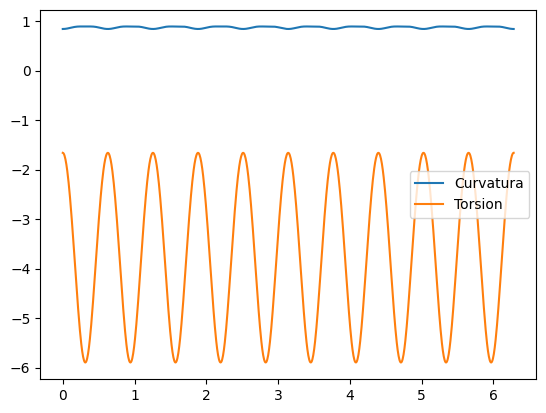

In [19]:
w = np.linspace(0, 2*np.pi, 1000)
ddα = α.diff(t,2)
κ = norma(dα.cross(ddα))/dα_norma**3
K = lambdify(t,κ.subs([(a, 4), (ω, 10)]))(w)
plt.plot(w,K, label = 'Curvatura')

db = B.diff(t)
τ = -db.dot(N)
Τ = lambdify(t,τ.subs([(a, 4), (ω, 10)]))(w)
plt.plot(w,Τ, label = 'Torsion')

plt.legend()
plt.show()

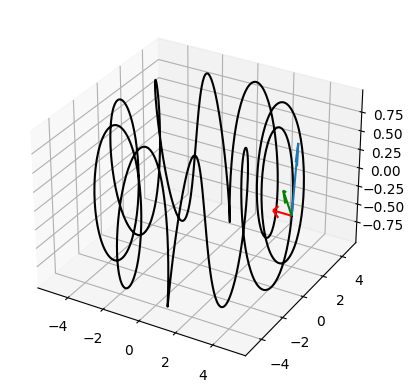

In [20]:
T0 = T.subs([(a, 4), (ω, 10), (t,0)])
N0 = N.subs([(a, 4), (ω, 10), (t,0)])
B0 = B.subs([(a, 4), (ω, 10), (t,0)])

X = x.subs([(a, 4), (ω, 10), (t,0)])
Y = y.subs([(a, 4), (ω, 10), (t,0)])
Z = z.subs([(a, 4), (ω, 10), (t,0)])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.quiver(X, Y, Z, T0[0], T0[1], T0[2])
ax.quiver(X, Y, Z, N0[0], N0[1], N0[2], color='red')
ax.quiver(X, Y, Z, B0[0], B0[1], B0[2], color='green')

X = lambdify(t, x.subs([(a, 4), (ω, 10)]))(w)
Y = lambdify(t, y.subs([(a, 4), (ω, 10)]))(w)
Z = lambdify(t, z.subs([(a, 4), (ω, 10)]))(w)
plt.plot(X,Y,Z, color = 'black')
plt.show()


## Bibliografia

- nicoavilan. (2022, julio 28) Visualizacion-de-datos/Mapas.ipynb at main · nicoavilan/Visualizacion-de-datos. GitHub. Recuperado de https://github.com/nicoavilan/Visualizacion-de-datos/blob/main/Mapas.ipynb
- nicoavilan. (2022, julio 28) Visualizacion-de-datos/Voronoi_KMeans.ipynb at main · nicoavilan/Visualizacion-de-datos. GitHub. Recuperado de https://github.com/nicoavilan/Visualizacion-de-datos/blob/main/Voronoi_KMeans.ipynb
- pandas.concat—Pandas 2.1.2 documentation. (s/f). Recuperado de https://pandas.pydata.org/docs/reference/api/pandas.concat.html
- scipy.integrate.quad—SciPy v1.11.3 Manual. (s/f). Recuperado de https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html
- Zach. (2022, octubre 10). Pandas: Check if Row in One DataFrame Exists in Another. Statology. https://www.statology.org/pandas-check-if-row-is-in-another-dataframe/